##**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

##**Aprendizaje Automático Profundo (Deep Learning)**

*Edición 2022*


**Integrantes:**


*   Abdala, Agustin
*   Acosta, Martín
*   Gonzalo Argüello
*   Matias Mengual
*   Mateo Ramos



----



## Ejercicio:
Implementar una red neuronal que asigne una categoría dado un título.
Para este práctico se puede usar cualquier tipo de red neuronal. Les que hagan solo la primera mitad de la materia,
implementarán un MLP. Quienes cursan la materia completa, deberían implementar algo más complejo, usando CNNs,
RNNs o Transformers.

Algunas consideraciones a tener en cuenta para estructurar el trabajo:



1.   Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).
2.   Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).
3.   Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros
4.   Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.
5.   Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.
6.   Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy (Macro-recall).

##Descarga de datos Meli Challenge 2019

In [ ]:

#CORRER UNA VEZ
!mkdir ./data
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
!curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/meli-challenge-2019.tar.bz2 -o ./data/meli-challenge-2019.tar.bz2
!tar jxvf ./data/meli-challenge-2019.tar.bz2 -C ./data/
!pip install mlflow
!pip install --upgrade gensim

## Librerías

In [1]:
import csv
import functools
import gzip
import pandas as pd
import json
import tempfile
import gzip
import json
import tqdm
import mlflow
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score

from gensim import corpora
from gensim.parsing import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from tqdm.notebook import tqdm, trange
from gensim.models import KeyedVectors
from torch.utils.data import Dataset, DataLoader, IterableDataset
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import classification_report

## Dataset

Para la ingesta del dataset utilizaremos un chunksize el cual nos permitira realizar ingesta cada 10000 datos dado el gran volumen de datos

####Train Set

In [ ]:
train_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.train.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
train_df

Dados los tiempos y el poder de procesamiento disponible utilizaremos 30000 datos, tomados al azar, de los 4895280 disponibles.
Se estima que aumentando este valor se mejorarian las metricas de los modelos propuestos

In [ ]:
#filtro = train_df.index < 30000
#train_df = train_df[filtro]
#train_df
train_df=train_df.sample(n = 30000, random_state = 0,ignore_index=True) 
train_df

In [ ]:
train_df.drop(['language','label_quality','split', 'tokenized_title', 'data', 'target', 'n_labels', 'size'], inplace=True, axis=1)

In [2]:
# Agregado por Guillermo Robiglio
ARCHIVO_SET_DE_ENTRENAMIENTO = './data/training_set.csv'
train_df = pd.read_csv(ARCHIVO_SET_DE_ENTRENAMIENTO)

print('Datos cargados con éxito, a continuación una muestra de los datos.')
train_df.head()

Datos cargados con éxito, a continuación una muestra de los datos.


,title,category
0,Casita Muñecas Barbies Pintadas,DOLLHOUSES
1,Neceser Cromado Holográfico,TOILETRY_BAGS
2,Funda Asiento A Medida D20 Chevrolet,CAR_SEAT_COVERS
3,Embrague Ford Focus One 1.8 8v Td (90cv) Desde...,AUTOMOTIVE_CLUTCH_KITS
4,Bateria Panasonic Dmwbcf10 Lumix Dmc-fx60n Dmc...,CAMERA_BATTERIES


In [ ]:
# Agregado por Guillermo Robiglio
train_df = train_df.sample(2000000)
train_df.shape

Se quitaran columnas que no se consideran necesarias para realizar la clasificación

In [ ]:
train_df

####Test Set

In [ ]:
test_df = pd.concat([x for x in pd.read_json('./data/meli-challenge-2019/spanish.validation.jsonl.gz', lines=True, chunksize=100000)], ignore_index=True)
test_df

In [ ]:
filtro = test_df.index < 30000
test_df = test_df[filtro]
test_df
#test_df=test_df.sample(n = 30000, random_state = 0, ignore_index=True) 
#test_df

In [ ]:
#test_df.reset_index(inplace=True, drop=True)

In [ ]:
test_df.drop(['language','label_quality','split', 'tokenized_title', 'data', 'target', 'n_labels', 'size'], inplace=True, axis=1)
test_df.head()

In [3]:
# Agregado por Guillermo Robiglio
ARCHIVO_SET_DE_PRUEBA = './data/test_set.csv'
test_df = pd.read_csv(ARCHIVO_SET_DE_PRUEBA)

print('Datos cargados con éxito, a continuación una muestra de los datos.')
test_df.head()

Datos cargados con éxito, a continuación una muestra de los datos.


,title,category
0,Metal Biela Dw10 Hdi 2.0,ENGINE_BEARINGS
1,Repuestos Martillo Rotoprcutor Bosch Gshsce Po...,ELECTRIC_DEMOLITION_HAMMERS
2,Pesca Caña Pejerrey Colony Brava 3m Fibra De V...,FISHING_RODS
3,Porcelanato Abitare Be 20x120 Cm. Ceramica Por...,PORCELAIN_TILES
4,Reconstruction Semi Di Lino Alfaparf Shampoo 1...,HAIR_SHAMPOOS_AND_CONDITIONERS


In [ ]:
# Agregado por Guillermo Robiglio
test_df = test_df.sample(500000)
test_df.shape

## Preprocesamiento

En este caso vamos a utilizar un sólo módulo para transformar los datos. Este se encargará de preprocesar el texto (i.e. normalizarlo) y transformará las palabras en índices de un diccionario para luego poder pasar una secuencia de palabras para buscar en la matriz de embeddings.

In [4]:
class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        # https://radimrehurek.com/gensim/corpora/dictionary.html
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary with extremos words
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.filter_extremes.html?highlight=filter_extrem
 #       self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        
        # Make the indices continuous after some words have been removed
        # https://tedboy.github.io/nlps/generated/generated/gensim.corpora.Dictionary.compactify.html
        self.dictionary.compactify()
                
        self.dictionary.patch_with_special_tokens({
          "[PAD]": 0, #The padding token
          "[UNK]": 1  # The unknown token
        })

        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}


    def _preprocess_string(self, string):
        # https://radimrehurek.com/gensim/parsing/preprocessing.html#gensim.parsing.preprocessing.preprocess_string:~:text=gensim.parsing.preprocessing.preprocess_string
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
      # https://radimrehurek.com/gensim/corpora/dictionary.html#:~:text=doc2idx(document,via%20unknown_word_index.
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target
        }

In [5]:
class MyDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "title"],
            "target": self.dataset.loc[item, "category"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

In [6]:
preprocess_train = RawDataProcessor(train_df)
train_dataset = MyDataset(train_df, transform=preprocess_train)

preprocess_test = RawDataProcessor(test_df)
test_dataset = MyDataset(test_df, transform=preprocess_test)

print(f"Datasets loaded with {len(train_dataset)} training elements and {len(test_dataset)} test elements")
print(f"Sample train element:\n{train_dataset[0]}")

Datasets loaded with 4895280 training elements and 1223820 test elements
Sample train element:
{'data': [385623, 2, 385622, 3], 'target': 188}


In [7]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [8]:
pad_sequences = PadSequences()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)

## Experimento de MLflow - MyMLP

Para el mismo se propone una red con la siguiente arquitectura:



*   Una capa de entrada con un embedding de 50 dimensiones y salida de tamaño 128.
*   Primer capa Oculta con entrada 128 y salidas 128

*   Segunda capa Oculta con entrada 128 y salidas 128
*   Una capa de Salida de entrada 128 y salida 632

Otros hiperparametros definidos son:


*   Learning Rate lr=1e-3
*   Optimizador Adam






In [9]:
class MyMLP(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()

        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        self.hidden1 = nn.Linear(vector_size, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 632)
        self.vector_size = vector_size
    
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
mlflow.set_experiment("Experiment_01_MLP")
EPOCHS = 3
with mlflow.start_run():
    mlflow.log_param("model_name", "mlp")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 50,
        "hidden1_size": 128,
        "hidden2_size": 128
    })
    model = MyMLP("../data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        model = MyMLP("../data/glove.6B.50d.txt.gz", preprocess_test.dictionary, 50, True)
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")

  0%|          | 0/1223820 [00:00<?, ?it/s]

####Curva Loss

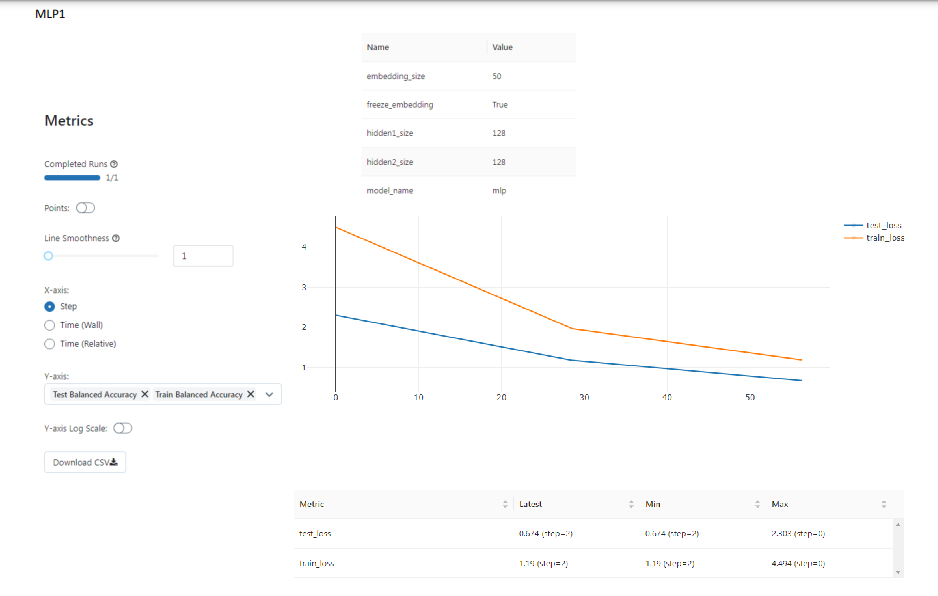

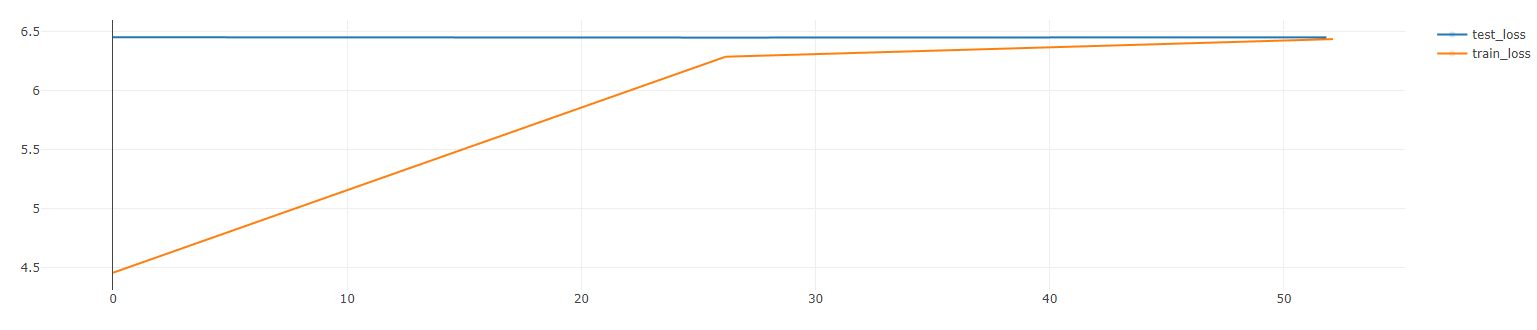

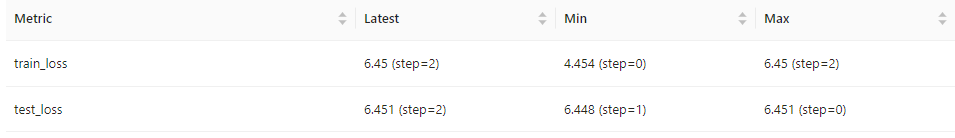

####Curva metrica (Balanced Accuracy)


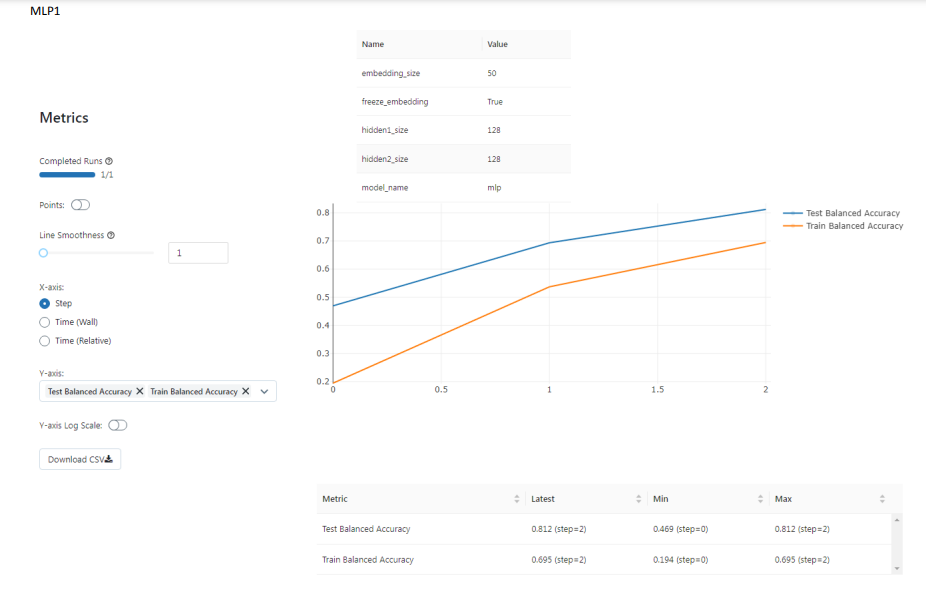

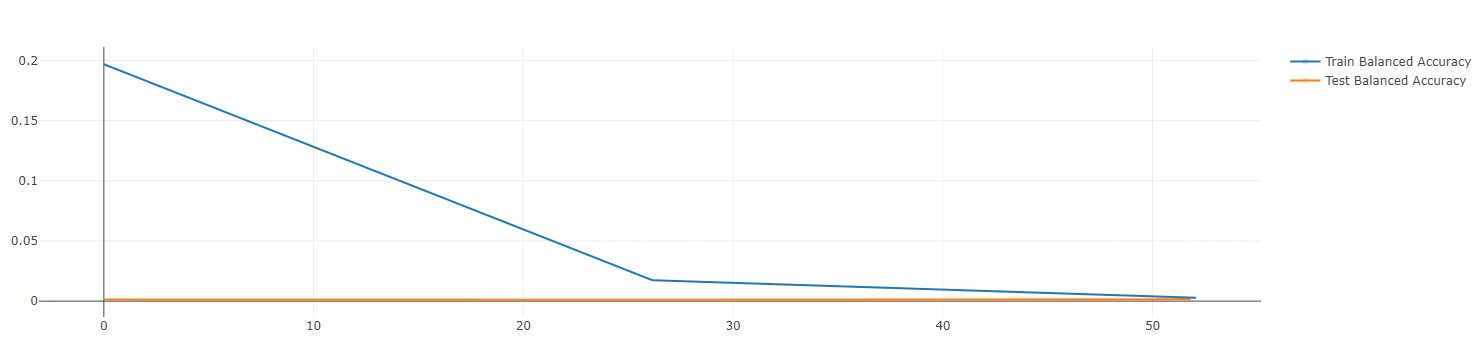

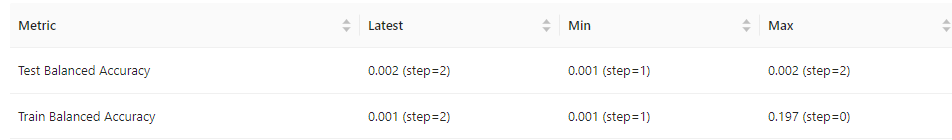

## Experimento de MLflow - MyMLP2

Para el mismo se propone una red con la siguiente arquitectura:



*   Una capa de entrada con un embedding de 50 dimensiones y salida de tamaño 128.
*   Primer capa Oculta con entrada  256 y salidas 256

*   Segunda capa Oculta con entrada  256 y salidas  256
*   Una capa de Salida con entrada 256 y salida  632

Otros hiperparametros definidos son:


*   Learning Rate lr=1e-2
*   Optimizador Adam

Como se puede ver, se duplican las salidas en las capas ocultas, se estima que esto podria mejorar el accuracy del modelo






In [ ]:
class MyMLP2(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()

        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        self.hidden1 = nn.Linear(vector_size, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.output = nn.Linear(256, 632)
        self.vector_size = vector_size

   
    def forward(self, x):
        x = self.embeddings(x)
        x = torch.mean(x, dim=1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        #print("1---", x.shape)
        x = self.output(x)
        return x

mlflow.set_experiment("Experiment_02_MLP")
EPOCHS = 3
with mlflow.start_run():
    mlflow.log_param("model_name", "mlp")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "embedding_size": 50,
        "hidden1_size": 256,
        "hidden2_size": 256
    })
    model = MyMLP2("./data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        model = MyMLP2("./data/glove.6B.50d.txt.gz", preprocess_test.dictionary, 50, True)
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
       

####Curva Loss

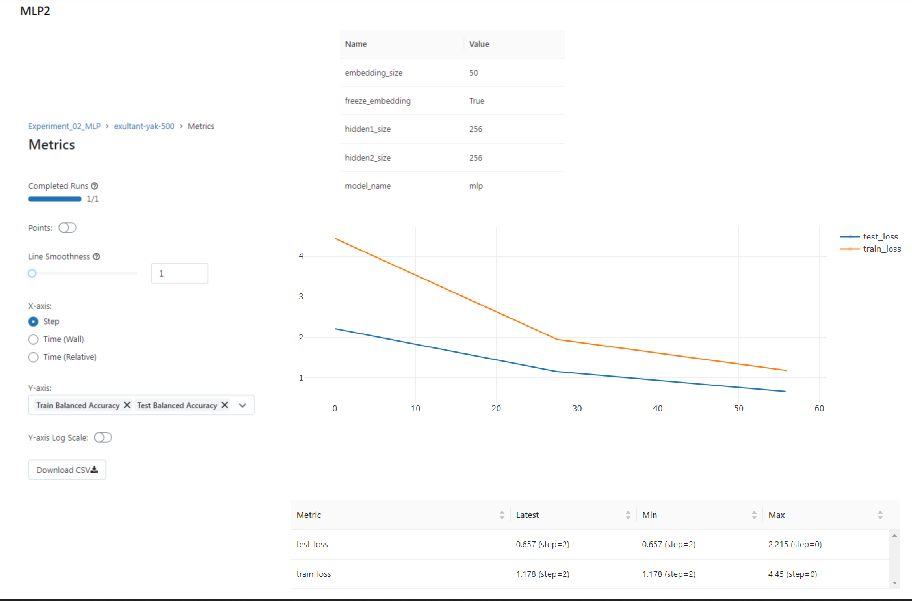

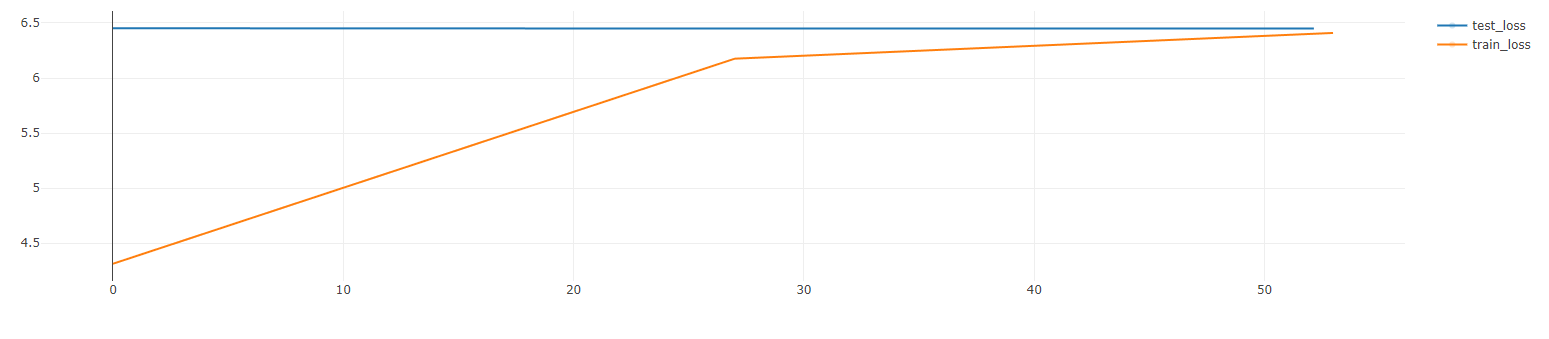

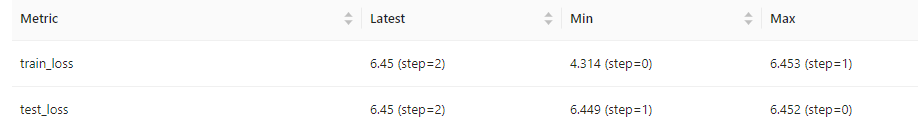

####Curva metrica (Balanced Accuracy)


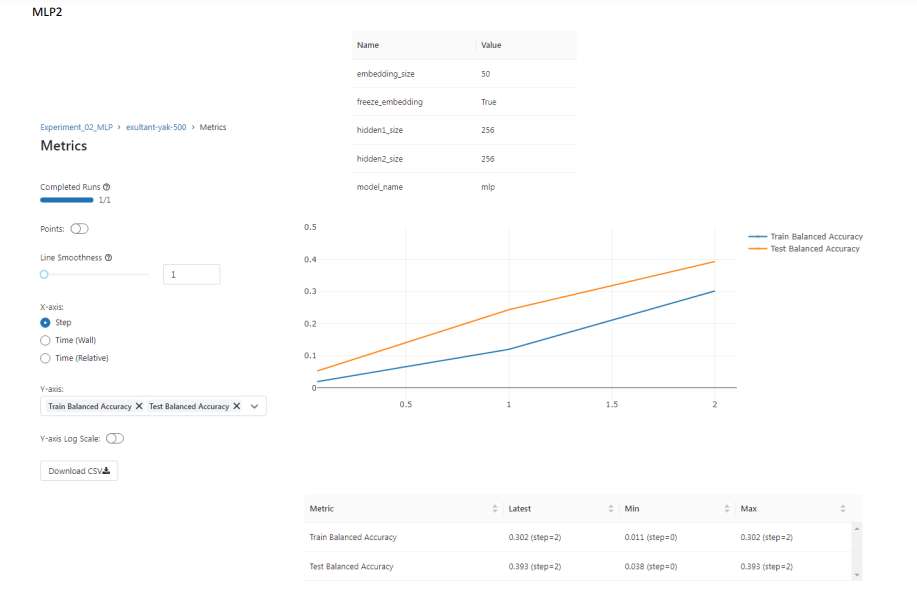

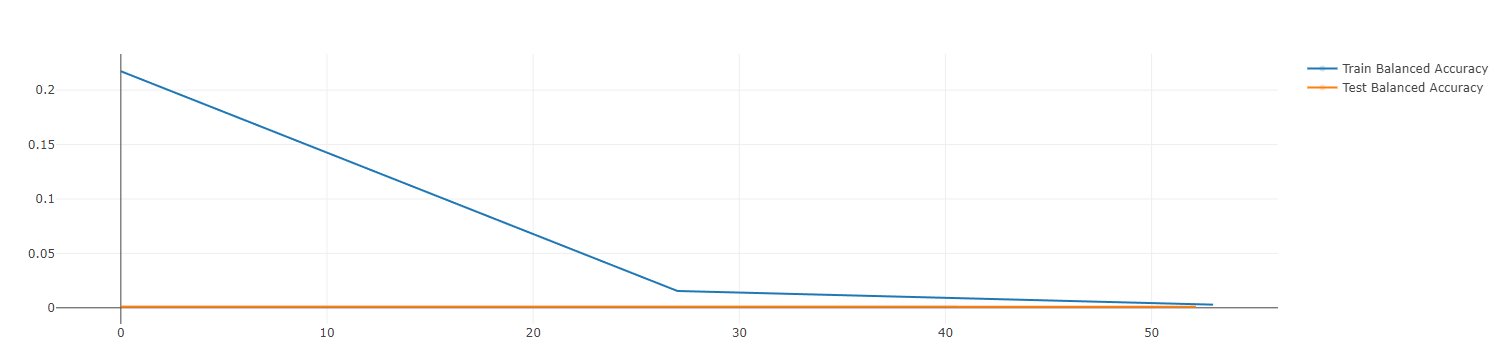

In [ ]:
!pip install pyngrok --quiet
!ngrok config add-authtoken 2FUCfvrAcm0MBdORxrIXshzwJN9_83QeBD6hRq6JsVERoSAnt

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2FUCfvrAcm0MBdORxrIXshzwJN9_83QeBD6hRq6JsVERoSAnt"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

# Comparación de modelos y seleccion del mejor modelo MLP

A continuación se pueden ver los valores finales de las metricas para cada modelo MLP que fueron reportadas en MLFLOW

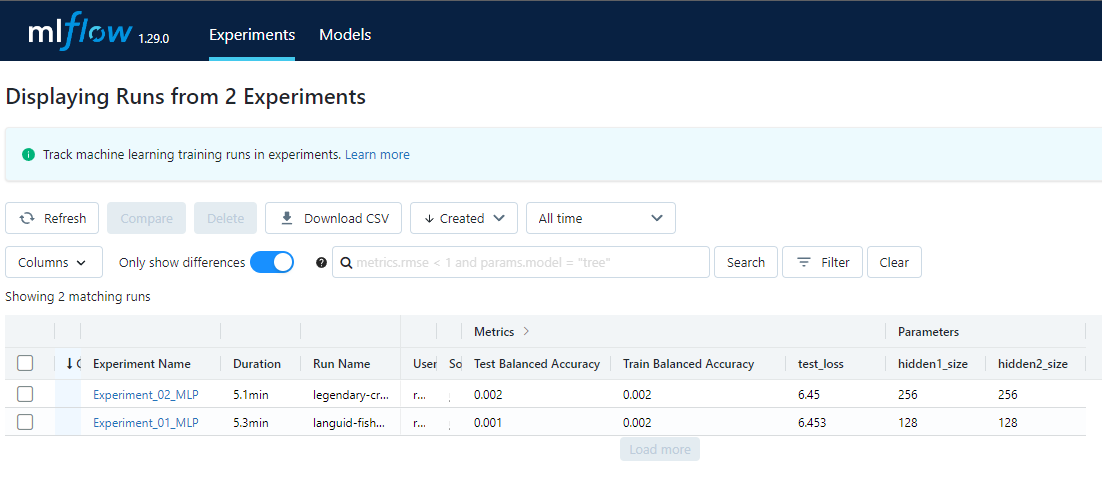

Tal lo visto en el reporte anterior el modelo MyMLP2 tiene un mayor Balanced Accuracy (0,2 %) por lo que este se considera el mejor modelos MLP obtenido

##PARTE 2: CNN

En esta seccion se presentan dos modelos con Redes Neuronales Convolucionales

In [ ]:
class PadSequences:
    def __init__(self, 
                 pad_value=0, 
                 max_length=None, 
                 min_length=1):
        
        assert max_length is None or min_length <= max_length #Sanity check
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            # Si no tenemos max_lenght definido, tomamos el mínimo entre min_lenght y
            # la longitud de la máxima secuencia
            max_length = max(self.min_length, max(seq_lengths))
        
        
        # Para secuencias cuya longitud es menor que max_lenght rellenamos los valores
        # faltantes con 0 (pad_value)
        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
    
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [ ]:
EPOCHS = 2
FILTERS_COUNT = 100
FILTERS_LENGTH = [2, 3, 4]

#Instanciamos las clases
pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False, num_workers=0)

## Experimento de MLflow - MyCNN

Para el mismo se propone una Convolutional Neural Network con la siguiente arquitectura:



*   Una capa de entrada con un embedding de 50 dimensiones y salida de FILTERS_COUNT(100) * FILTERS_LENGTH ([2, 3, 4])
*   Una capa convolucional FC (Fully Connected)con una entrada de FILTERS_COUNT(100) * FILTERS_LENGTH ([2, 3, 4]) y  salida 128
*   Una capa de Salida con entrada 128 y salida  632

Otros hiperparametros definidos son:


*   Learning Rate lr=1e-3
*   Optimizador Adam


In [ ]:
class MyCNN(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        
        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght) #(in_channels, out_channels, kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 128)
        self.output = nn.Linear(128, 632)
        self.vector_size = vector_size
        
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
mlflow.set_experiment("Experiment_03_CNN")
EPOCHS = 2
with mlflow.start_run():
    mlflow.log_param("model_name", "cnn")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    })

    model = MyCNN("./data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        model = MyCNN("./data/glove.6B.50d.txt.gz", preprocess_test.dictionary, 50, True)
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
       


####Curva Loss

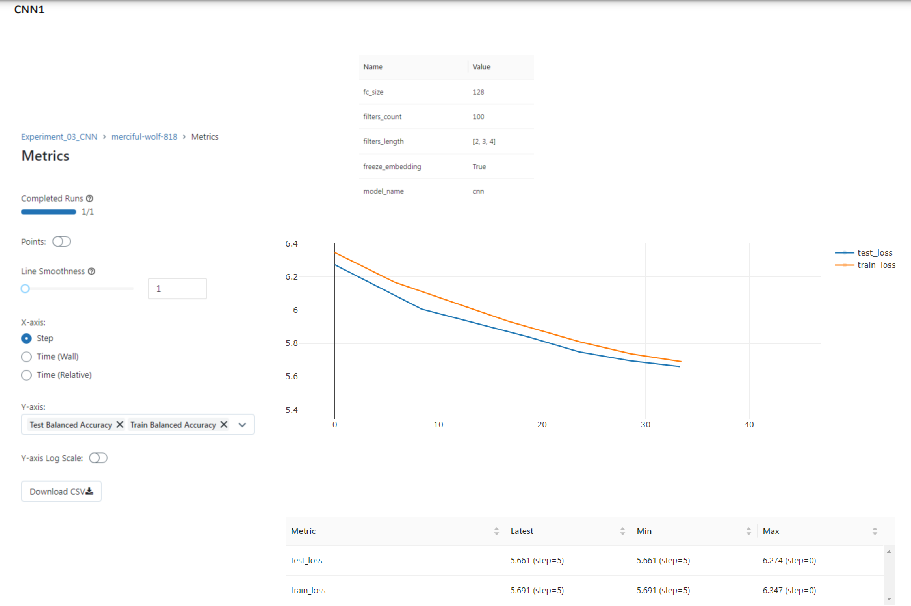

####Curva metrica (Balanced Accuracy)


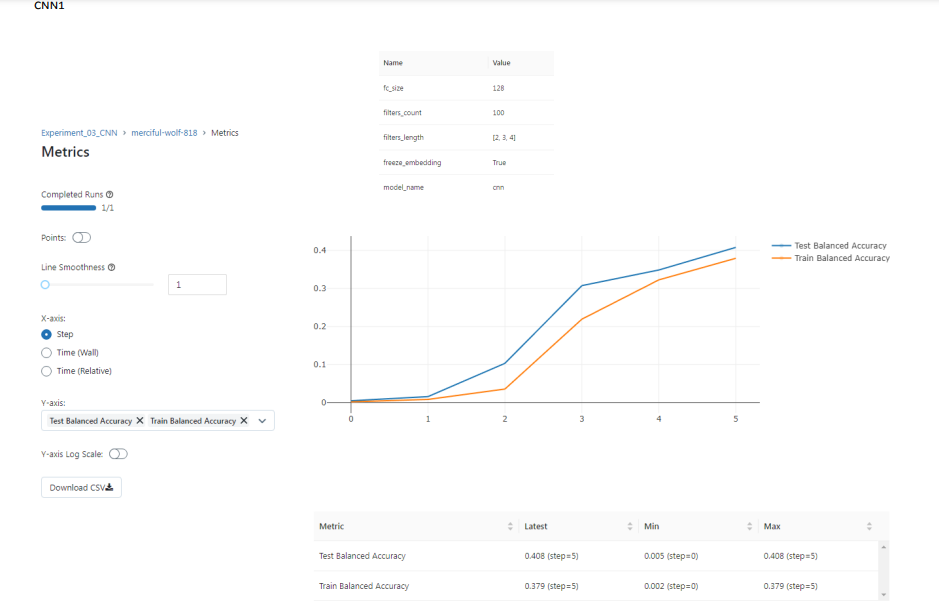

## Experimento de MLflow - MyCNN2

Para el mismo se propone una Convolutional Neural Network con la siguiente arquitectura:



*   Una capa de entrada con un embedding de 50 dimensiones y salida de FILTERS_COUNT(100) * FILTERS_LENGTH ([2, 3, 4])
*   Una capa convolucional FC (Fully Connected)con una entrada de FILTERS_COUNT(100) * FILTERS_LENGTH ([2, 3, 4]) y  salida 256
*   Una capa de Salida con entrada 256 y salida  632

Otros hiperparametros definidos son:


*   Learning Rate lr=1e-2
*   Optimizador Adam

Como se puede ver, se duplica la salida en la capa convolucional, se estima que esto podria mejorar el accuracy del modelo

In [ ]:
class MyCNN2(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 freeze_embedings):
        super().__init__()
        
        self.embeddings = nn.Embedding(len(dictionary), 50, 0) 

        
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght) #(in_channels, out_channels, kernel_size)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 256)
        self.output = nn.Linear(256, 632)
        self.vector_size = vector_size
        
    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = torch.sigmoid(self.output(x))
        return x

In [ ]:
mlflow.set_experiment("Experiment_04_CNN")
EPOCHS = 6
with mlflow.start_run():
    mlflow.log_param("model_name", "cnn")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 256
    })

    model = MyCNN2("./data/glove.6B.50d.txt.gz", preprocess_train.dictionary, 50, True)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
    for epoch in range(EPOCHS):
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []

        for idx, batch in enumerate(tqdm(train_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            optimizer.zero_grad()
            inputs, labels = batch["data"], batch["target"]
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            loss_value = loss(output, batch["target"].squeeze().long())
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Train Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)

       
        model.eval()
        model = MyCNN2("./data/glove.6B.50d.txt.gz", preprocess_test.dictionary, 50, True)
        model.to(device)
        running_loss = []
        y_true = []
        y_pred = []
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            inputs, labels = batch["data"], batch["target"]
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            _, predicted = torch.max(output.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            running_loss.append(
                loss(output, batch["target"].squeeze().long()).item()
            )
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric("Test Balanced Accuracy", balanced_accuracy_score(y_true, y_pred), epoch)


    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for idx, batch in enumerate(tqdm(test_loader)):
            batch['data'] = batch['data'].to(device)
            batch['target'] = batch['target'].to(device)
            output = model(batch["data"])
            targets.extend(batch["target"].cpu().numpy())
            predictions.extend(output.cpu().squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")
       


####Curva Loss

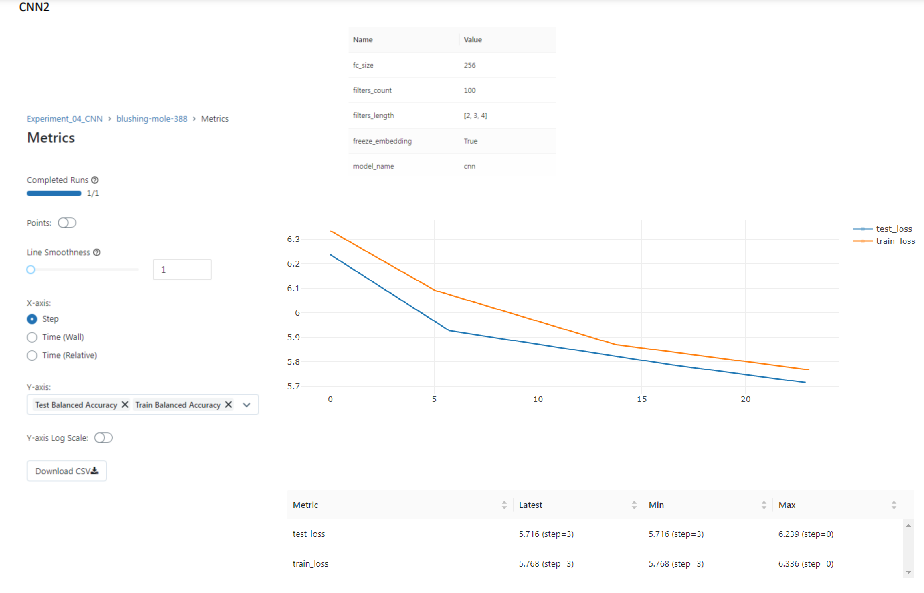

####Curva metrica (Balanced Accuracy)


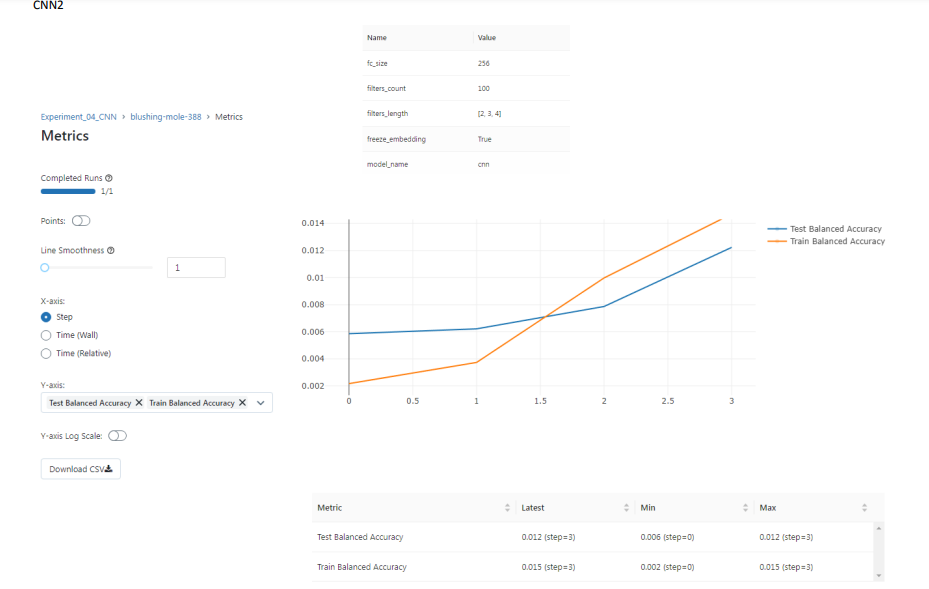

# Comparación de modelos y seleccion del mejor modelo CNN

A continuación se pueden ver los valores finales de las metricas para cada modelo CNN que fueron reportadas en MLFLOW

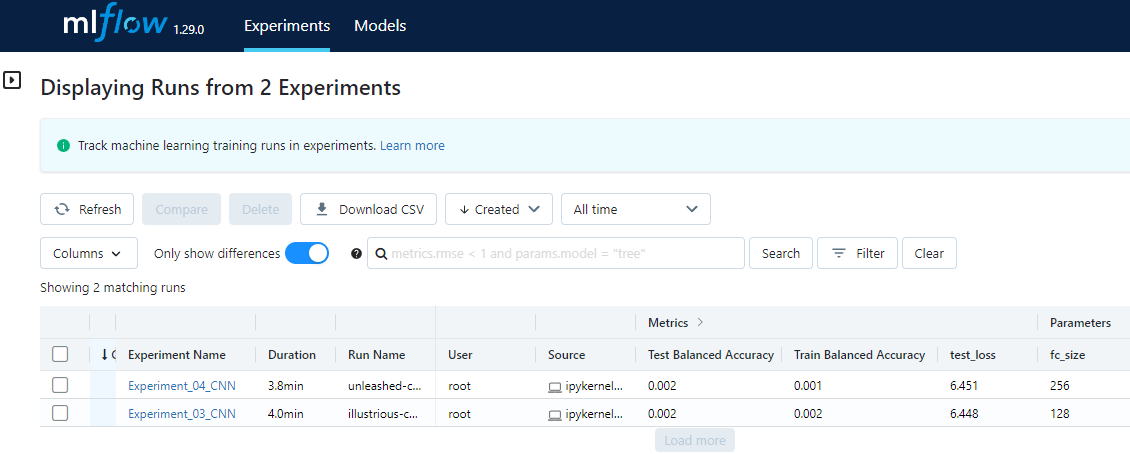

Tal lo visto en el reporte anterior el modelo MyCNN2, tiene el mismo Balanced Accuracy que el modelo MyCNN2 (0,2 %), pero tiene un mtiempo de procesamiento menor (3.8 min) por lo que se considera el mejor de los modelos CNN

In [ ]:
# Zipeamos y bajamos la carpeta de experimentos MLRUNS
!zip -r /content/mlruns.zip /content/mlruns